In [1]:
from numpy import *
from matplotlib import pyplot
from networkx import *
import pandas
from random import *
from numba import jit # A Just In Time compiler for speeding up Python code

In [2]:
# Convert variant code from list form to string form
@jit(nopython=True)
def toString(code):
    return ' '.join([str(i) for i in code])

In [3]:
# Get the previous variant code
@jit(nopython=True)
def getPreviousCode(adjacency):
    size = len(adjacency[0]) - 1
    previous_code = zeros(size, dtype = int64)
    for i in range(size):
        previous_code[i] = adjacency[0, i + 1]
    return previous_code

In [4]:
def sizeSelector():
    size = 0
    generation_method = input("Generation method (R / r - random, M / m - manual): ")
    while generation_method.casefold() != 'r' and generation_method.casefold() != 'm' :
        generation_method = input("Input must be 'R', 'r', 'M', or 'm': ")
    if generation_method.casefold() == 'r' :
        # You don't really want more than 101 weapons :P
        size = randint(3, 101)
        while size % 2 == 0:
            size = randint(3, 101)
    elif generation_method.casefold() == 'm' :
        size = int(input("Enter the number of 'weapons' (the number must be an odd number greater than 1): "))
        while size % 2 == 0 or size < 3 :
            size = int(input("The number must be an odd number greater than 1: "))
    return size

In [5]:
def generationSelector(size):
    next_code = zeros(size, dtype = int64)
    generation_method = input("Generation method (R / r - random, M / m - manual): ")
    while generation_method.casefold() != 'r' and generation_method.casefold() != 'm' :
        generation_method = input("Input must be 'R', 'r', 'M', or 'm': ")
    if generation_method.casefold() == 'r' :
        next_code = sample(range(1, size+1), size)
    elif generation_method.casefold() == 'm' :
        print(f"Enter a number such that  1 ≤ number ≤ {size}")
        print("For every number, press enter")
        print("Entrees must only occur once: ")
        for i in range(size):
            holder = int(input())
            # if input is outside 1 ≤ number ≤ size or already in next_code
            while size < holder or holder < 1 or holder in next_code :
                holder = int(input("Please try again: "))
            next_code[i] = holder
    return next_code

In [6]:
# Get the previous variant code
def getNextCode(previous_code):
    change_variant = input("Change variant code? (Y / y - yes, N / n - no): ")
    while change_variant.casefold() != "y" and change_variant.casefold() != "n" :
        change_variant = input("Input must be 'Y', 'y', 'N', or 'n': ")
    if change_variant.casefold() == 'n':
        return previous_code
    elif change_variant.casefold() == 'y':
        #------------------------ Size ----------------------- #
        size = 0
        change_size = input("Change the number of weapons? (Y / y - yes, N / n - no): ")
        while change_size.casefold() != 'y' and change_size.casefold() != 'n' :
            change_size = input("Input must be 'Y', 'y', 'N', or 'n': ")
        if change_size.casefold() == 'n':
            size = len(previous_code)
        elif change_size.casefold() == 'y':
            size = sizeSelector()
        #------------------------ Contents ----------------------- #
        return generationSelector(size)

In [7]:
# Get intial adjacency matrix of the strength-weakness (SW) graph
# Contents determine the direction of the edges in the SW graph
# This is the starting configuration
@jit(nopython=True)
def getInitialAdjacency(size):
    # count(-1) == count(1)
    # Counters for -1s
    counter = zeros(size, dtype = int64)
    # Adjacency matrix for the SW graph
    adjacency = zeros((size + 1, size + 1), dtype = int64)
    for i in range(size + 1):
        # Header column and header row
        adjacency[0, i] = i
        adjacency[i, 0] = i
        # Body of the matrix
        for j in range (i, size + 1):
            # Diagonals: 0
            if i == j:
                adjacency[j, i] = 0
            else:
                # All of the following statements are equivalent:
                # Every row:    count(-1) == (size - 1) / 2
                # Every column: count(-1) == (size - 1) / 2
                # Every row:    count(1)  == (size - 1) / 2
                # Every column: count(1)  == (size - 1) / 2
                if counter[i - 1] < (size - 1) / 2:
                    adjacency[j, i] = -1
                    adjacency[i, j] = 1
                    counter[i - 1] += 1
                else:
                    adjacency[j, i] = 1
                    adjacency[i, j] = -1
    return adjacency

In [8]:
# Format and print adjacency matrix
def FnPAdjacency(size, adjacency):
    for i in range(size + 1):
        for j in range(size + 1):
            if(j == 0  and i != j):
                print(i, end = "\t")
            elif(j == size):
                if(i == 0):
                    print(j)
                elif(adjacency[i, j] == 1):
                    print("W")
                elif(adjacency[i, j] == 0):
                    print("D")
                elif(adjacency[i, j] == -1):
                    print("L")
            else:
                if(i == 0):
                    print(j, end = "\t")
                elif(adjacency[i, j] == 1):
                    print("W", end = "\t")
                elif(adjacency[i, j] == 0):
                    print("D", end = "\t")
                elif(adjacency[i, j] == -1):
                    print("L", end = "\t")

In [9]:
# Longest Prefix Suffix
@jit(nopython=True)
def LPS(pattern, pattern_length, lps):
    len = 0 # Length of the previous longest prefix suffix
    lps[0] = 0 # lps[0] is always 0
    i = 1
    # calculates lps[i] for i = 1 to pattern_length-1
    while i < pattern_length:
        if pattern[i] == pattern[len]:
            len += 1
            lps[i] = len
            i += 1
        else:
            # This is tricky. Consider the example:
            # AAACAAAA and i = 7. 
            # The idea is similar to the search step.
            if len != 0:
                len = lps[len-1]
                # Note: i is not incremented here
            else:
                lps[i] = 0
                i += 1

In [10]:
# Knuth–Morris–Pratt Algorithm
# Find the instances of pattern in text
@jit(nopython=True)
def KMP(text, pattern):
    text_length = len(text)
    pattern_length = len(pattern)
    # Create lps[] that will hold the longest prefix suffix
    # Values for pattern
    lps = zeros(pattern_length, dtype = int64)
    # i := Index for text[]
    # j := Index for pattern[]
    i = j = 0
    # Preprocess the pattern (calculate lps[] array)
    LPS(pattern, pattern_length, lps)
    while i < text_length:
        if pattern[j] == text[i]:
            i += 1
            j += 1
        if j == pattern_length:
            j = lps[j - 1]
            return True
        # Mismatch after j matches 
        elif i < text_length and pattern[j] != text[i]:
            # Do not match the characters in lps[0 ... j - 1], 
            # since they will match anyway
            if j != 0:
                j = lps[j - 1]
            else:
                i += 1
    return False

In [11]:
# Check if the next and previous variant codes are rotations of each other
@jit(nopython=True)
def areRotations(next_code, previous_code):
    if len(next_code) != len(previous_code) : 
        return False 
    concatenated = next_code + next_code
    return KMP(concatenated, previous_code)

In [12]:
# Check if the next and previous variant codes are the same
@jit(nopython=True)
def areEqual(next_code, previous_code):
    for i in range(len(next_code)):
        if next_code[i] != previous_code[i] :
            return False
    return True

In [13]:
# Find the indices of the mismatches in previous_code
@jit(nopython=True)
def findIndices(next_code, previous_code):
    index_1 = index_2 = 0
    while next_code[index_1] == previous_code[index_1]:
        index_1 += 1
    holder = next_code[index_1]
    index_2 = index_1
    while holder != previous_code[index_2]:
        index_2 += 1
    return index_1 + 1, index_2 + 1

In [14]:
# Swap the rows and then columns of the adjacency matrix
@jit(nopython=True)
def swap(index_1, index_2, adjacency):
    for i in range(size + 1): 
        # Swap rows
        temp = adjacency[index_1, i]
        adjacency[index_1, i] = adjacency[index_2, i]
        adjacency[index_2, i] = temp
    for i in range(size + 1):
        # Swap columns
        temp = adjacency[i, index_1]
        adjacency[i, index_1] = adjacency[i, index_2]
        adjacency[i, index_2] = temp
    return adjacency

In [15]:
# previous_code (previous variant code): 
#   header row (or equivalently, column) of the previous arrangement of the adjacency matrix
# next_code (next variant code):
#    header row (or equivalently, column) of the next arrangement of the adjacency matrix
# adjacency:
#    adjacency matrix of the strength-weakness chart
@jit(nopython=True)
def rearrange(next_code, previous_code, adjacency):
    index_1 = index_2 = 0
    # Check if the codes are rotations of each other
    if not areRotations(previous_code, next_code):
        # While the two codes are not equal
        while not areEqual(next_code, previous_code):
            # Find the indices of the mismatches
            index_1, index_2 = findIndices(next_code, previous_code)
            # Swap the rows and then the columns of the adjacency matrix
            swap(index_1, index_2, adjacency)
            previous_code = getPreviousCode(adjacency)
    else:
        return adjacency

In [16]:
@jit(nopython=True)
def judge(name1, name2, player1, player2, adjacency):
    if(adjacency[player1, player2] == -1):
        print(name2 + " wins")
    elif(adjacency[player1, player2] == 0):
        print("DRAW")
    elif(adjacency[player1, player2] == 1):
        print(name1 + " wins")

In [17]:
@jit(nopython=True)
def printIntroduction():
    print("\t\t\tWelcome to Complicated Rock-Papper-Scissors!")
    print("Weapons don't have names. Instead they are designated with numbers")
    print("The table represents win-lose chart, which determines what happens to Player 1 depending on what the participants play")
    print("The 1st column is for which weapon Player 1 plays")
    print("The 1st  row   is for which weapon Player 2 plays")
    print("e.g.")
    print("Given the following win-lose chart:")
    print("  1 2 3 4 5")
    print("1 D W W L L")
    print("2 L D W W L")
    print("3 L L D W W")
    print("4 W L L D W")
    print("5 W W L L D")
    print("and the participants play the following:")
    print("Player 1: 1")
    print("Player 2: 3")
    print("The result: Player 1 wins")

In [18]:
# Generates edges
def generateEdges(values, graph):
    for i in range(len(values[0])):
        for j in range(i):
            if values[i, j] == -1:
                graph.add_edge(str(j+1), str(i+1))
            elif values[i, j] == 1:
                graph.add_edge (str(i+1), str(j+1))
            

In [19]:
# Generate network graph using adjacency
def showGraph(adjacency, code):
    graph = networkx.DiGraph()
    for i in code:
        graph.add_node(str(i))
    values = adjacency[1:, 1:]
    generateEdges(values, graph)
    pyplot.figure(3,figsize=(20,20)) 
    networkx.draw_circular(graph, 
                           with_labels=True,
                           arrows=True,
                           node_size=500,
                           node_color='white',
                           width=1,
                           arrowstyle='-|>',
                           arrowsize=10)
    pyplot.show()

In [20]:
class Player:
    play = 0
    def __init__(self, name):
        self.name = name
    
    def setPlay(self, play):
        self.play = play

Variant Code: 1 2 3 4 5 6 7 8 9 10 11 12 13


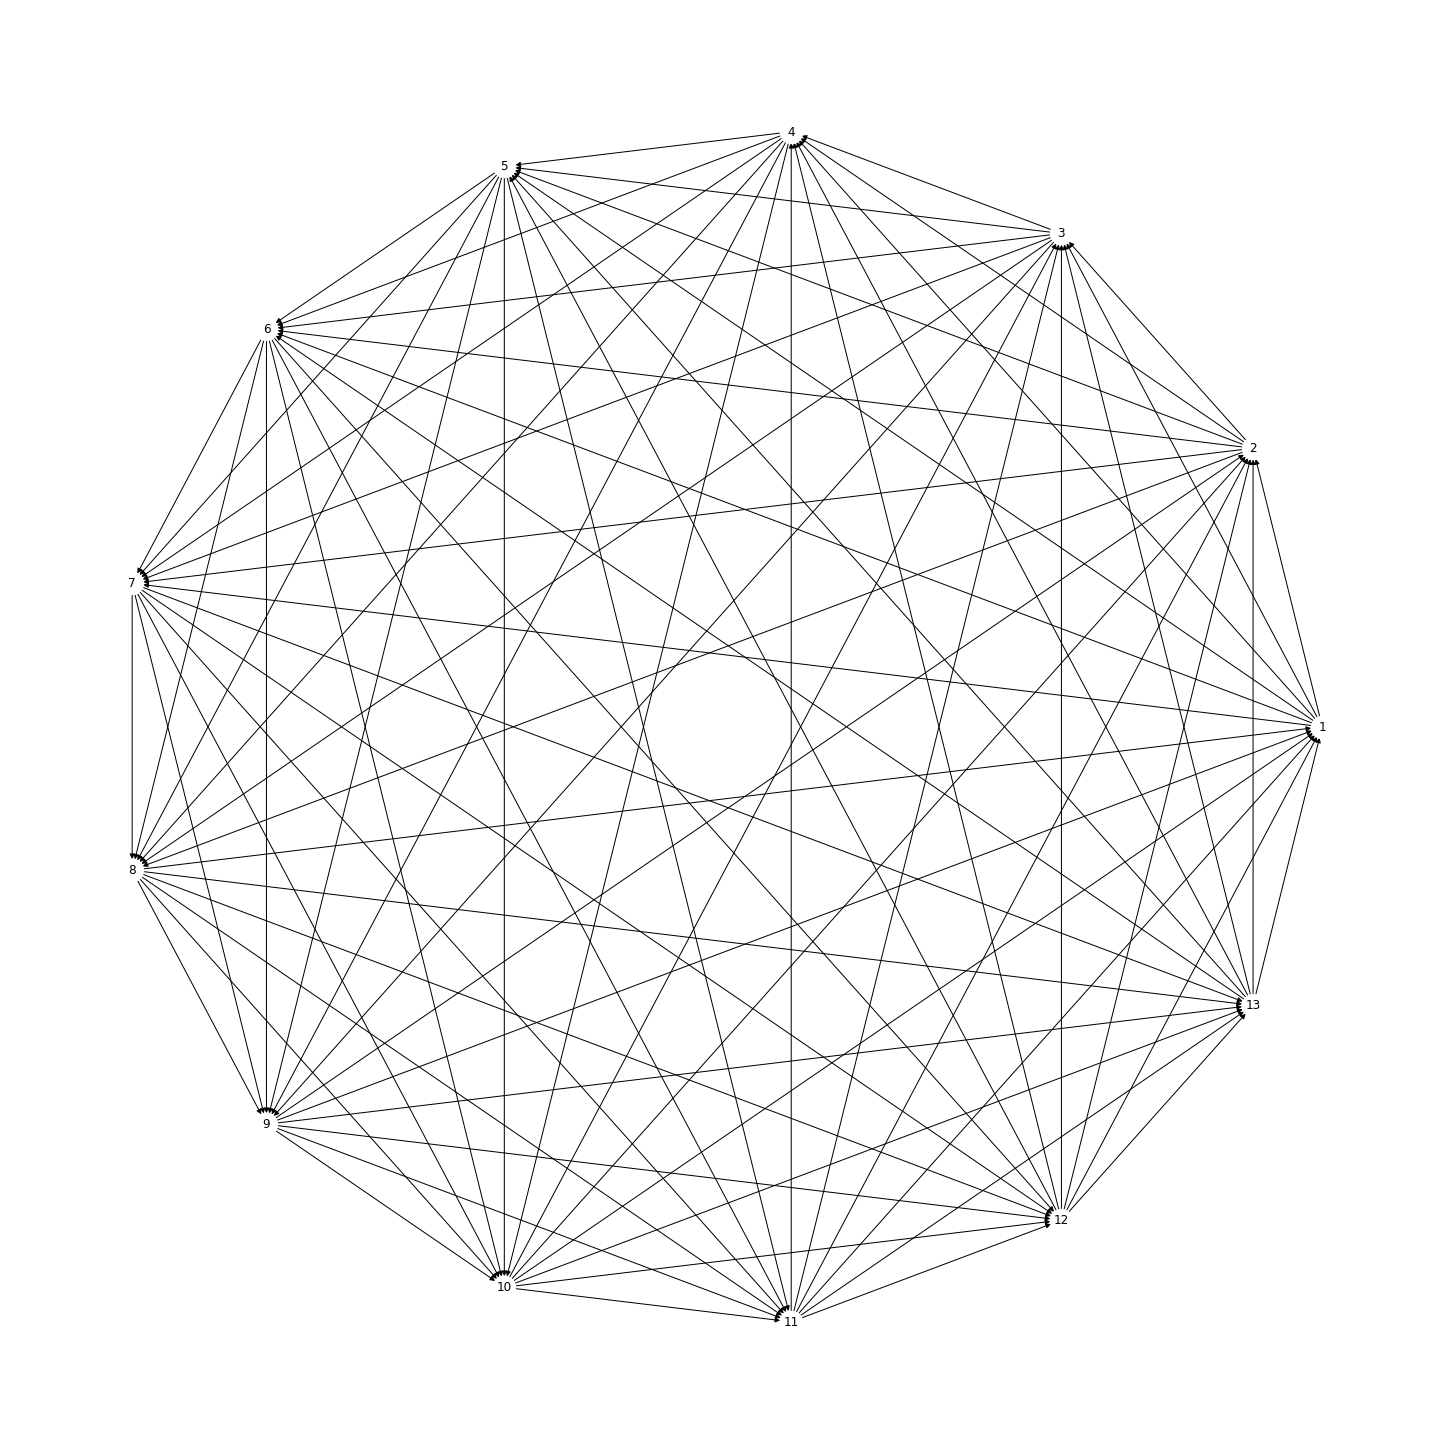

0	1	2	3	4	5	6	7	8	9	10	11	12	13
1	D	W	W	W	W	W	W	L	L	L	L	L	L
2	L	D	W	W	W	W	W	W	L	L	L	L	L
3	L	L	D	W	W	W	W	W	W	L	L	L	L
4	L	L	L	D	W	W	W	W	W	W	L	L	L
5	L	L	L	L	D	W	W	W	W	W	W	L	L
6	L	L	L	L	L	D	W	W	W	W	W	W	L
7	L	L	L	L	L	L	D	W	W	W	W	W	W
8	W	L	L	L	L	L	L	D	W	W	W	W	W
9	W	W	L	L	L	L	L	L	D	W	W	W	W
10	W	W	W	L	L	L	L	L	L	D	W	W	W
11	W	W	W	W	L	L	L	L	L	L	D	W	W
12	W	W	W	W	W	L	L	L	L	L	L	D	W
13	W	W	W	W	W	W	L	L	L	L	L	L	D


In [21]:
size = 13
adjacency = getInitialAdjacency(size)
previous_code = getPreviousCode(adjacency)
code_string = toString(previous_code)
print("Variant Code: " + code_string)
showGraph(adjacency, previous_code)
FnPAdjacency(size, adjacency)

			Welcome to Complicated Rock-Papper-Scissors!
Weapons don't have names. Instead they are designated with numbers
The table represents win-lose chart, which determines what happens to Player 1 depending on what the participants play
The 1st column is for which weapon Player 1 plays
The 1st  row   is for which weapon Player 2 plays
e.g.
Given the following win-lose chart:
  1 2 3 4 5
1 D W W L L
2 L D W W L
3 L L D W W
4 W L L D W
5 W W L L D
and the participants play the following:
Player 1: 1
Player 2: 3
The result: Player 1 wins




Enter name for Player 1: Hans
Enter name for Player 2: Cross
Generation method (R / r - random, M / m - manual): m
Enter the number of 'weapons' (the number must be an odd number greater than 1): 5
Variant Code: 1 2 3 4 5


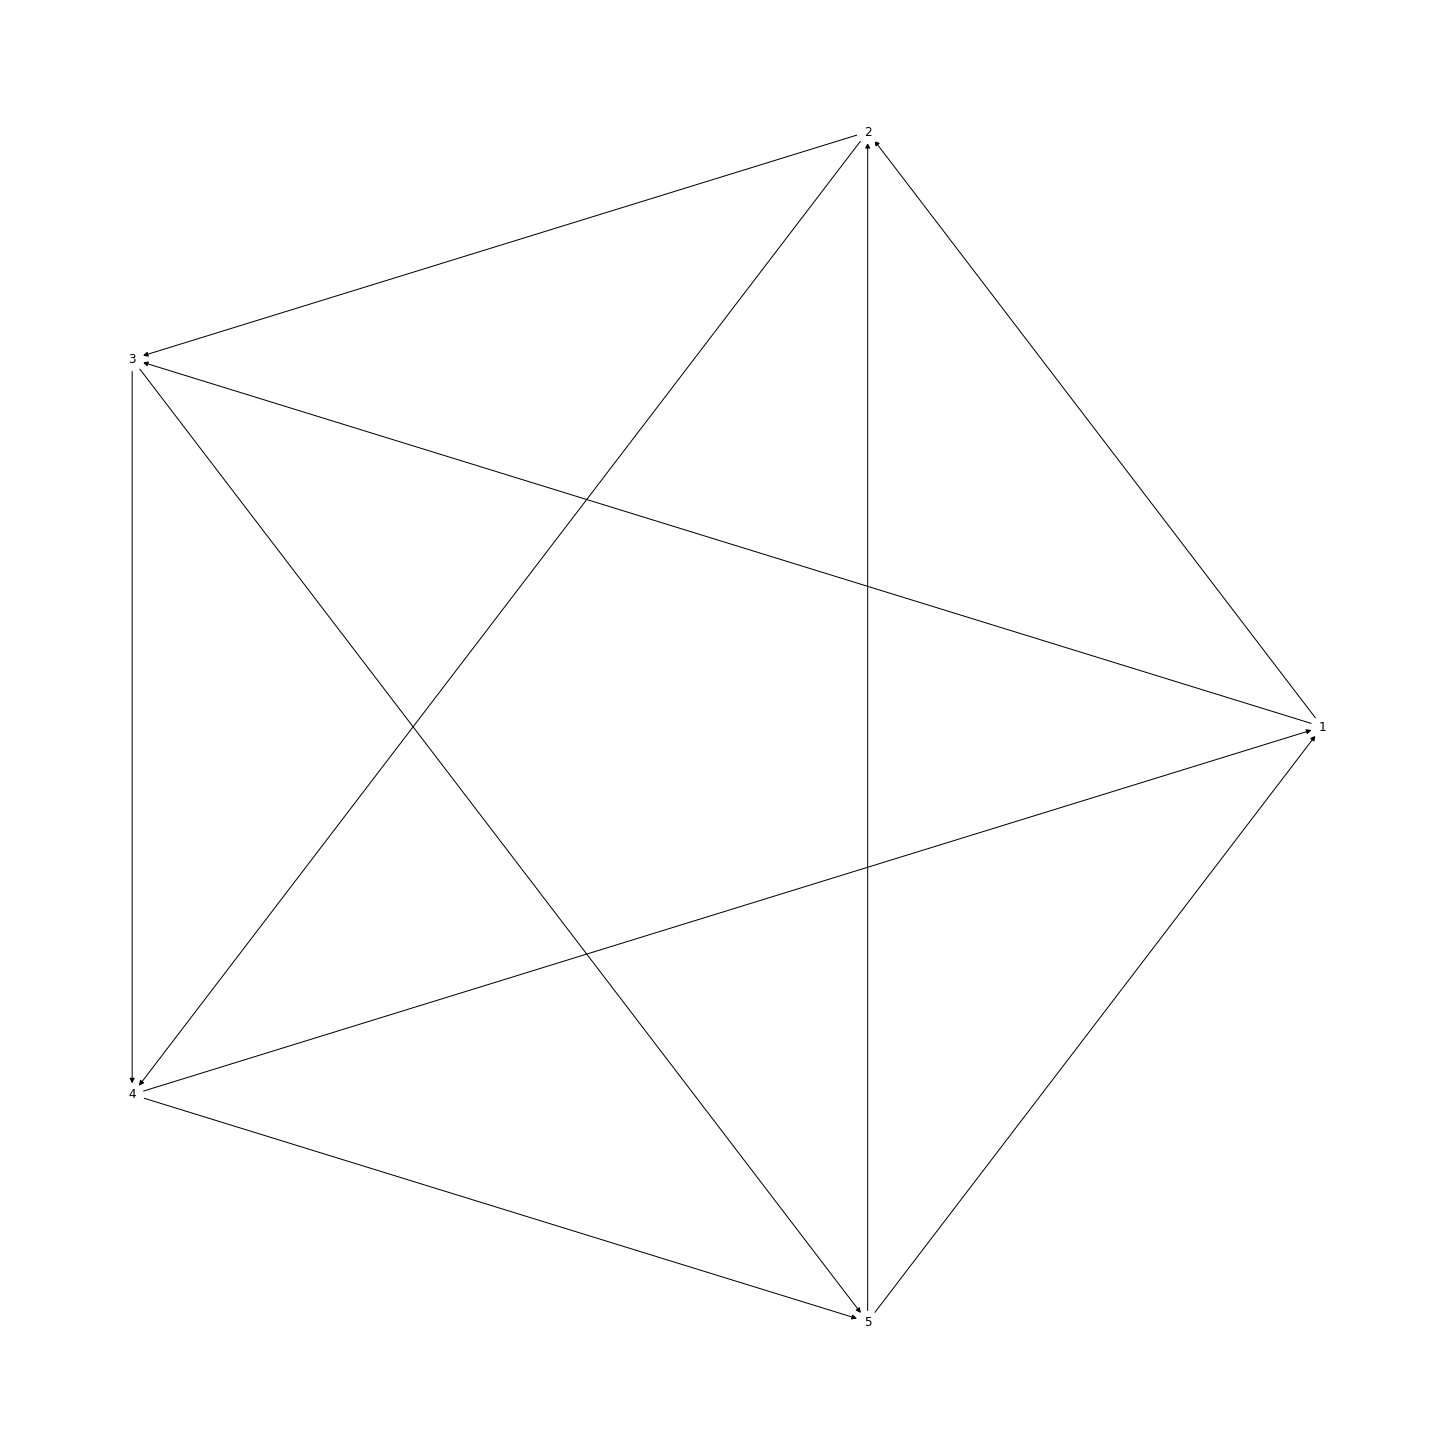

0	1	2	3	4	5
1	D	W	W	L	L
2	L	D	W	W	L
3	L	L	D	W	W
4	W	L	L	D	W
5	W	W	L	L	D


In [22]:
printIntroduction()

print("\n\n\n")

name1 = input("Enter name for Player 1: ")
name2 = input("Enter name for Player 2: ")

size = sizeSelector()

# 1D int arrays: previous_code, next_code
# 2D int array: adjacency

adjacency = getInitialAdjacency(size)
previous_code = getPreviousCode(adjacency)
print("Variant Code: " + toString(previous_code))
showGraph(adjacency, previous_code)
FnPAdjacency(size, adjacency)

Change variant code? (Y / y - yes, N / n - no): y
Change the number of weapons? (Y / y - yes, N / n - no): n
Generation method (R / r - random, M / m - manual): r
Variant Code: 5 3 4 1 2


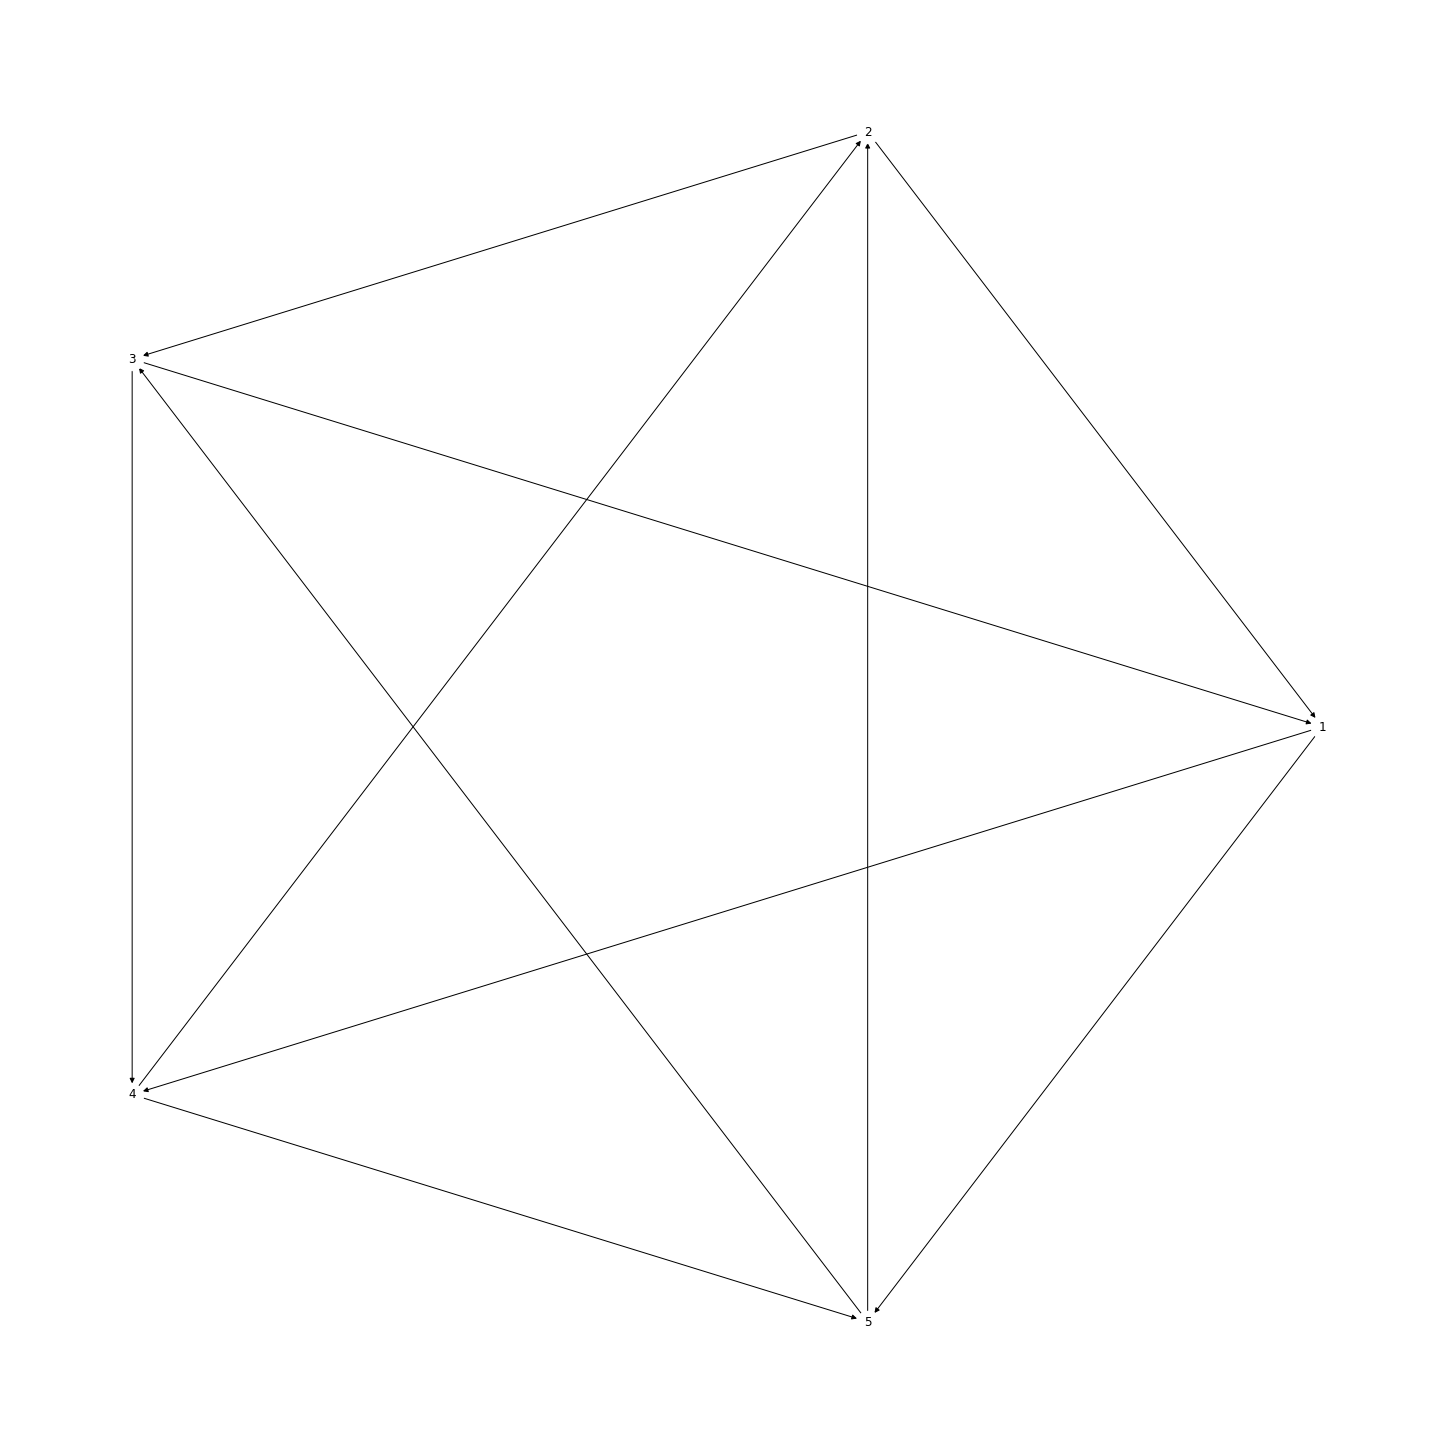

0	1	2	3	4	5
1	D	L	L	W	W
2	W	D	W	L	L
3	W	L	D	W	L
4	L	W	L	D	W
5	L	W	W	L	D


In [23]:
next_code = copy(getNextCode(previous_code))
rearrange(next_code, previous_code, adjacency)
print("Variant Code: " + toString(next_code))
showGraph(adjacency, previous_code)
FnPAdjacency(size, adjacency)

In [24]:
previous_code = next_code
print(f"Enter a number such that  1 ≤ number ≤ {size}")
player1 = int(input("Player 1: "))
while size < player1 or player1 < 1 :
    player1 = int(input("Please try again: "))
    
player2 = int(input("Player 2: "))
while size < player2 or player2 < 1 :
    player2 = int(input("Please try again: "))

judge(name1, name2, player1, player2, adjacency)

Enter a number such that  1 ≤ number ≤ 5
Player 1: 1
Player 2: 1
DRAW
